# Neural nets for BO


Source: https://gdmarmerola.github.io//ts-for-bayesian-optim/

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [41]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    # returning
    return out

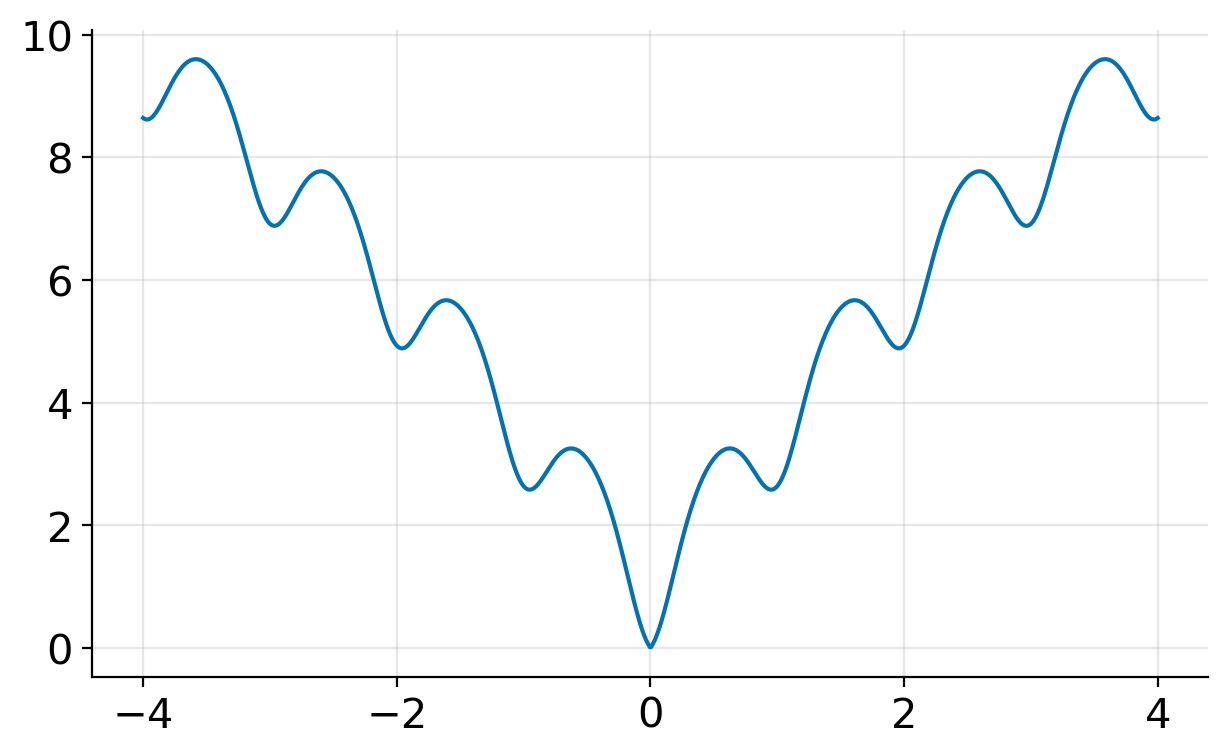

In [7]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
# yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [8]:
class MLP(nn.Module):
    n_hidden: int = 20

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [9]:
key = jax.random.PRNGKey(314)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [147]:
n_obs = 15
x_samples = jax.random.uniform(key_data, shape=(n_obs,1), minval=-4, maxval=4)

In [93]:
y_samples = ackley_1d(x_samples)
# y_samples = (y_samples - ymean) / ystd

In [94]:
def callback(bel_update, bel_pred, y, x, agent):
    Ht = agent.grad_mean(bel_update.mean, x)
    yhat = agent.mean_fn(bel_update.mean, x).astype(float)
    err = y - yhat - Ht @ (bel_pred.mean - bel_update.mean)
    return jnp.abs(err)

In [125]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=1)
bel_init = agent.init_bel(params_init, cov=0.001 ** 2)

# replacing last-layer covariance
bel_init = bel_init.replace(W=bel_init.W.at[-21:, -21:].set(jnp.eye(21) * 10.0))

bel, hist = agent.scan(bel_init, y_samples, x_samples, callback)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 17.5 s, sys: 213 ms, total: 17.7 s
Wall time: 2.52 s


In [126]:
hist.squeeze()

array([9.6835 , 0.36201, 3.95885, 0.20294, 0.87675, 0.03739, 0.3553 , 0.13021, 5.82887, 5.15467, 0.27403, 0.1826 , 0.08874, 1.76221, 0.07219], dtype=float32)

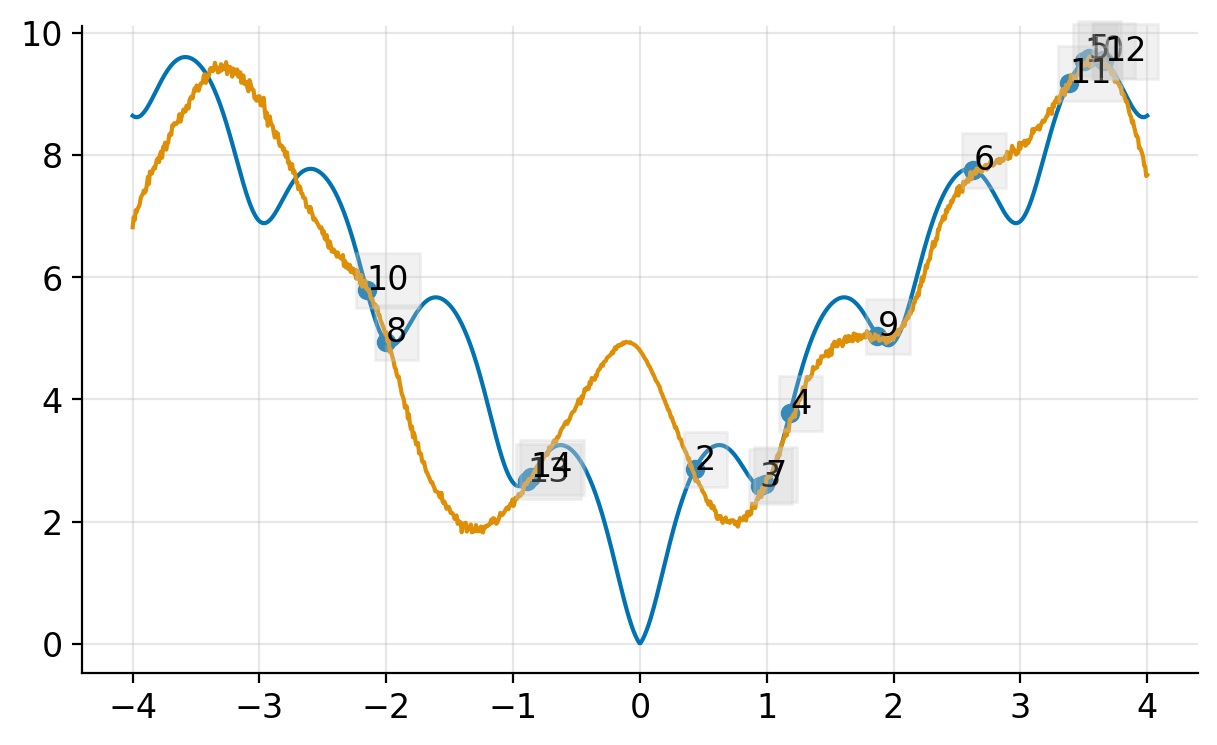

In [127]:
plt.scatter(x_samples, y_samples)

for i, (x, y) in enumerate(zip(x_samples, y_samples)):
    plt.text(x.item(), y.item(), i, fontsize=12, backgroundcolor="#ccc4")

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)
plt.plot(xrange, agent.mean_fn(bel.mean, xrange[:, None]))

## Copy

In [128]:
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (20,), 'kernel': (1, 20)},
  'Dense_1': {'bias': (20,), 'kernel': (20, 20)},
  'Dense_2': {'bias': (20,), 'kernel': (20, 20)},
  'last_layer': {'bias': (1,), 'kernel': (20, 1)}}}

In [129]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

In [130]:
sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

In [131]:
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

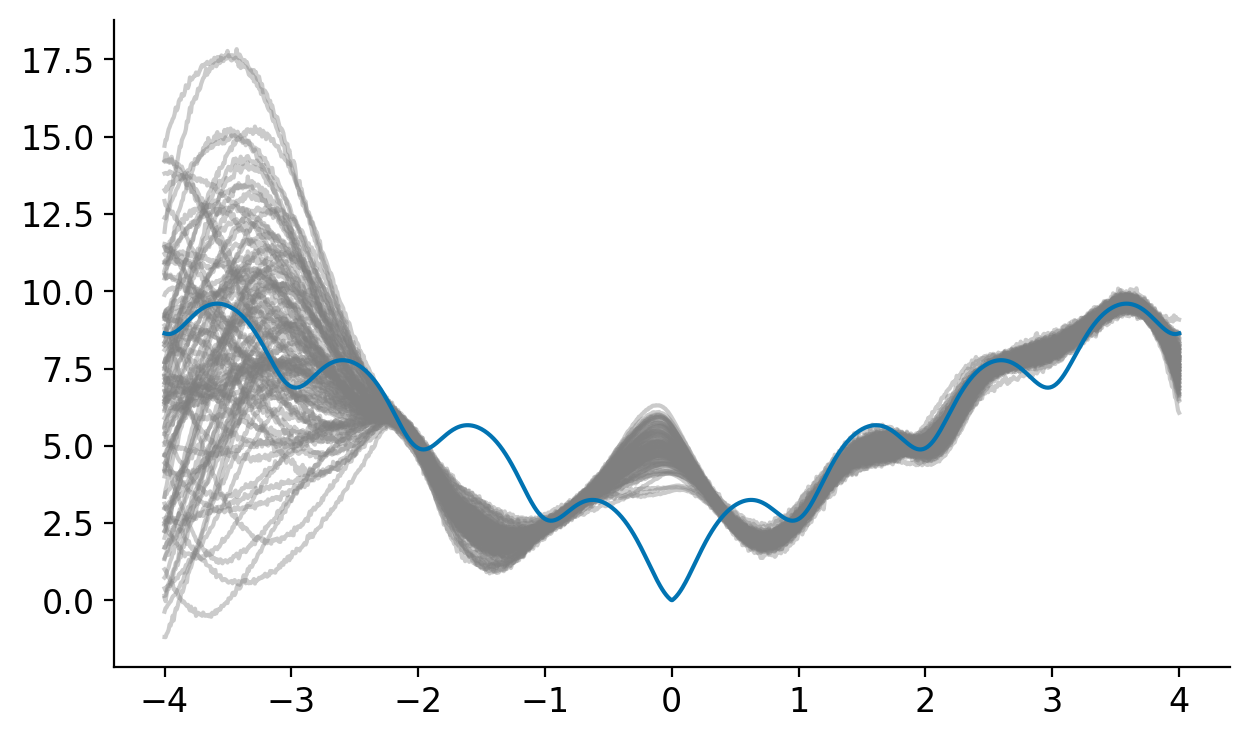

In [132]:
plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

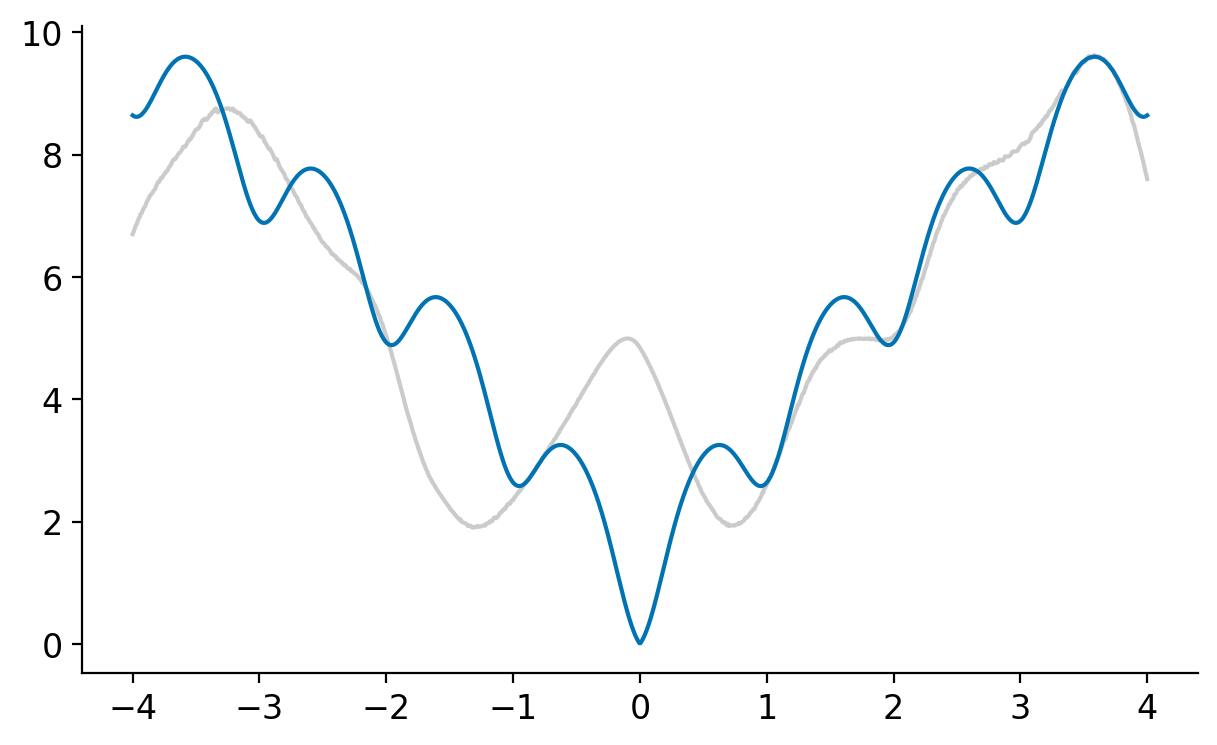

In [133]:
plt.plot(xrange, eval_samples.mean(axis=0), c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

## Sampling from last-layer only

In [134]:
dim_ll = 21
W_ll = bel.W[-dim_ll:, -dim_ll:]
mean_ll = bel.mean[-dim_ll:]

In [140]:
eps = jax.random.normal(key_sample, (100, dim_ll))

In [141]:
mean_hidden = bel.mean[:-dim_ll]

In [142]:
sample_params = jnp.einsum("ji,sj->si", W_ll, eps) + mean_ll

In [143]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    params = jnp.concat([hidden_params, ll_params])
    return agent.mean_fn(params, x).squeeze()

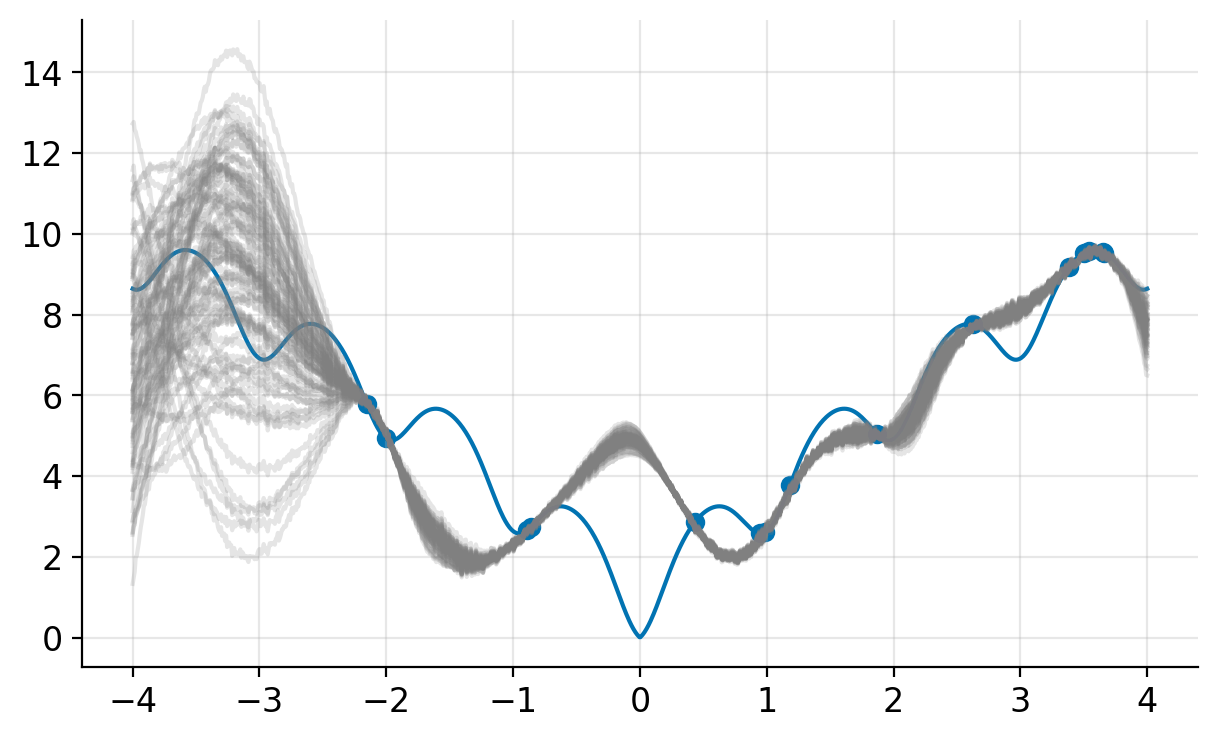

In [146]:
plt.plot(xrange, yvals)
ysamples = join_eval(sample_params, mean_hidden, xrange[:, None])
plt.plot(xrange, ysamples.T, c="gray", alpha=0.2)
plt.grid(alpha=0.3)
plt.scatter(x_samples, y_samples);

# Low-rank last layer

In [150]:
from rebayes_mini.methods import low_rank_last_layer as l3rkf
from rebayes_mini.callbacks import get_updated_mean

In [151]:
x_samples = jax.random.uniform(key_data, shape=(10,1), minval=-4, maxval=4)

In [152]:
y_samples = ackley_1d(x_samples)
# y_samples = (y_samples - ymean) / ystd

In [153]:
def callback(bel_update, bel_prior, y, x, agent):
    return bel_update
    yhat = agent.mean_fn(bel_update.mean_hidden, bel_update.mean_last, x)
    R_half = jnp.linalg.cholesky(jnp.atleast_2d(agent.covariance(yhat)), upper=True)
    # Jacobian for hidden and last layer
    J_hidden = agent.jac_hidden(bel_update.mean_hidden, bel_update.mean_last, x)
    J_last = agent.jac_last(bel_update.mean_hidden, bel_update.mean_last, x)

    # Innovation
    err = y - yhat - J_hidden @ (bel_prior.mean_hidden - bel_update.mean_hidden) - J_last @ (bel_prior.mean_last - bel_update.mean_last)

    return jnp.abs(err)

In [154]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = l3rkf.LowRankLastLayer(
    model.apply, cov_fn, rank=20, dynamics_hidden=0.0, dynamics_last=0.0,
)
# agent = olli.LowRankLastLayerIt(
#     model.apply, cov_fn, rank=200, dynamics_hidden=0.0, dynamics_last=1e-5,
#     n_it_hidden=1, n_it_last=1
# )
bel_init = agent.init_bel(params_init, cov_hidden=0.01, cov_last=10.0)

cfn = partial(callback, agent=agent)
bel, hist = agent.scan(bel_init, y_samples, x_samples, cfn)
bel = jax.block_until_ready(bel)

CPU times: user 1.45 s, sys: 148 ms, total: 1.6 s
Wall time: 957 ms


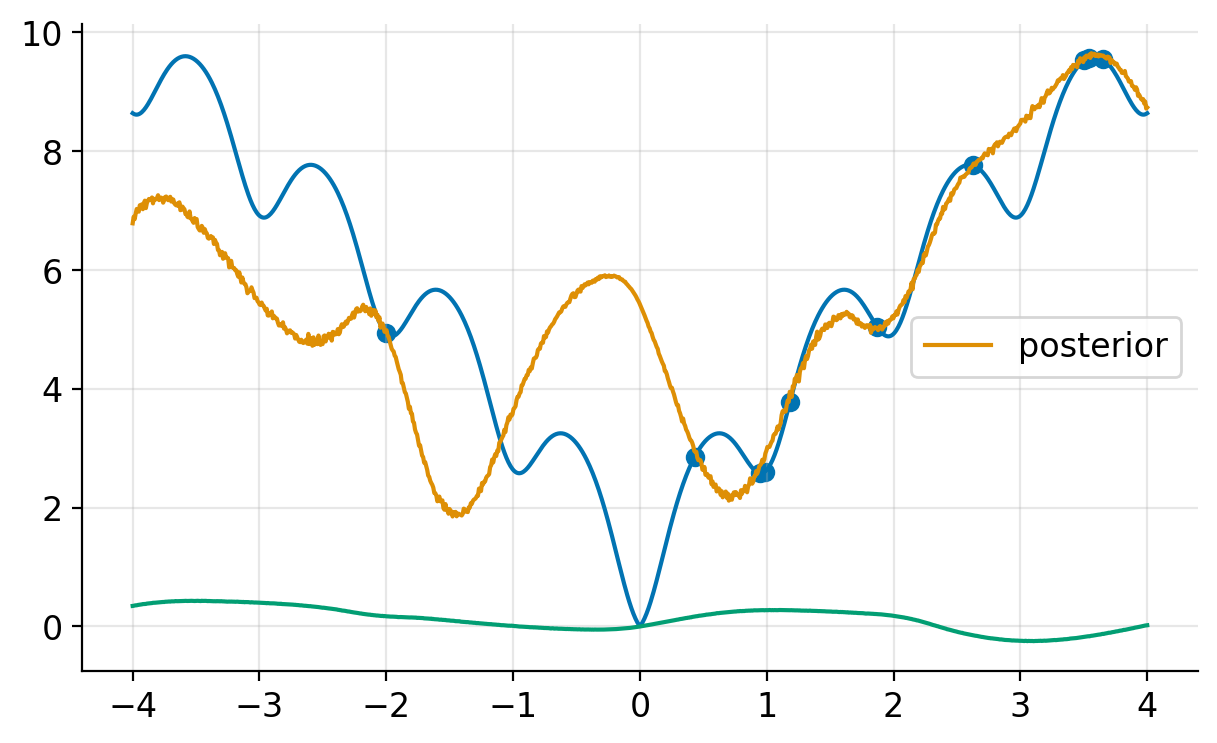

In [155]:
plt.scatter(x_samples, y_samples)

plt.plot(xrange, yvals)
plt.plot(xrange, agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]), label="posterior")
plt.plot(xrange, agent.mean_fn(bel_init.mean_hidden, bel_init.mean_last, xrange[:, None]))
plt.legend()
plt.grid(alpha=0.3)

In [156]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    return agent.mean_fn(hidden_params,ll_params, x).squeeze()

In [157]:
bel_step = jax.tree.map(lambda x: x[-1], hist)
sample_params = agent.sample_params_last_layer(key_sample, bel_step, n_samples=100)
ysamples = join_eval(sample_params, bel.mean_hidden, xrange[:, None])

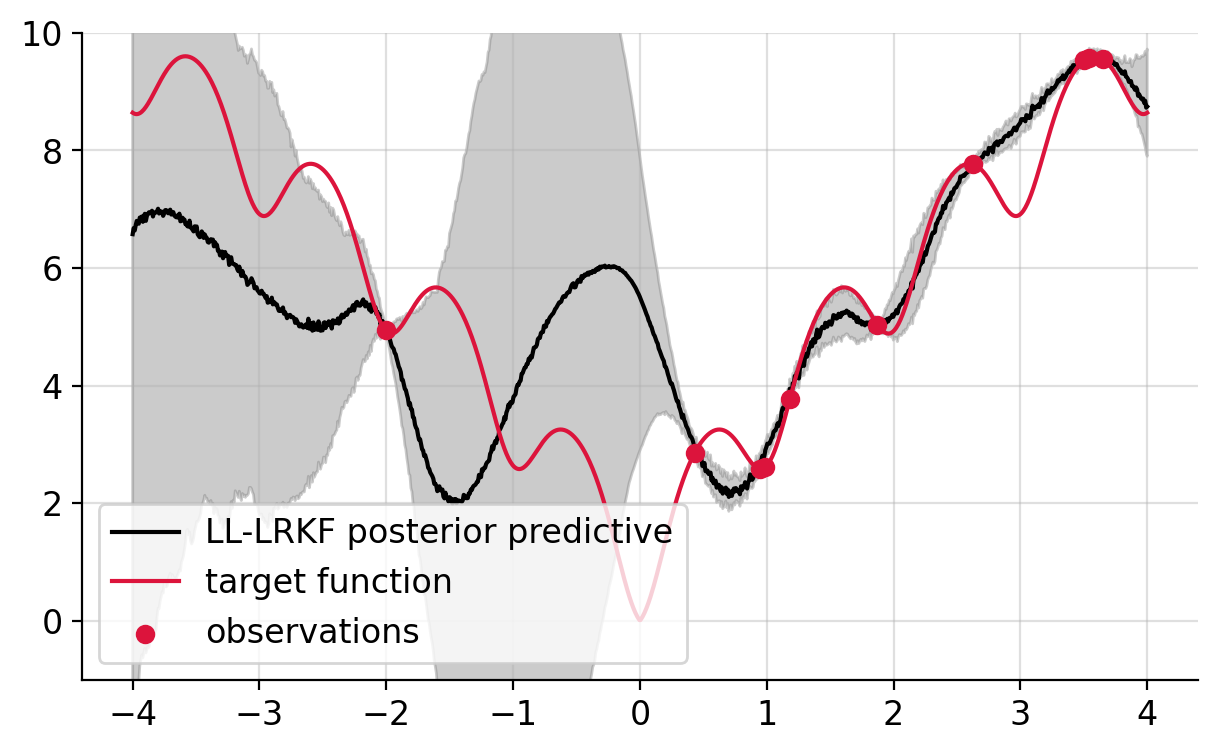

In [158]:
lbound = np.quantile(ysamples, 0.1, axis=0)
ubound = np.quantile(ysamples, 0.9, axis=0)

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)
plt.plot(xrange, ysamples.mean(axis=0), c="black", label="LL-LRKF posterior predictive")
plt.plot(xrange, yvals, c="crimson", label="target function")
plt.ylim(-1, 10)
plt.scatter(x_samples, y_samples, zorder=3, c="crimson", label="observations")
plt.legend(loc="lower left")
# plt.plot(xrange, ysamples[:5].T, c="tab:gray");
plt.grid(alpha=0.4)

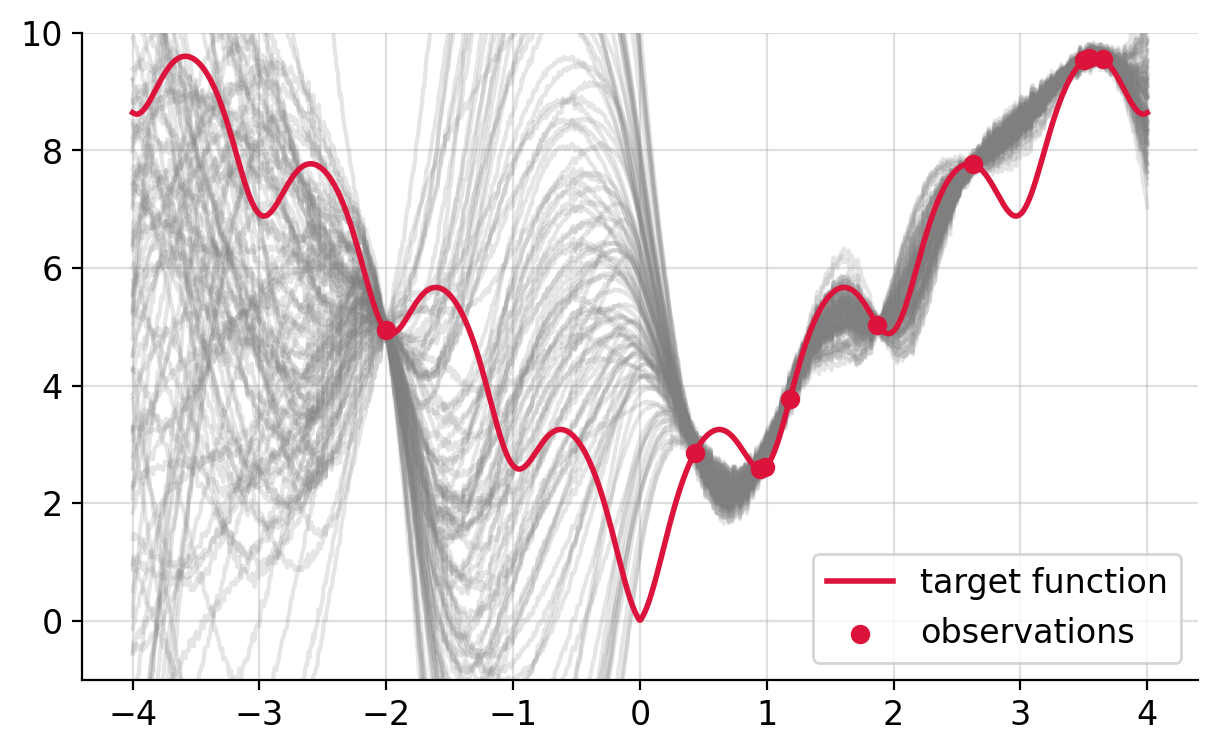

In [159]:
plt.plot(xrange, ysamples.T, c="tab:gray", alpha=0.2)
plt.plot(xrange, yvals, c="crimson", linewidth=2, label="target function")
plt.scatter(x_samples, y_samples, zorder=3, color="crimson", label="observations")
plt.ylim(-1, 10)
plt.legend()
plt.grid(alpha=0.4)

## Steps

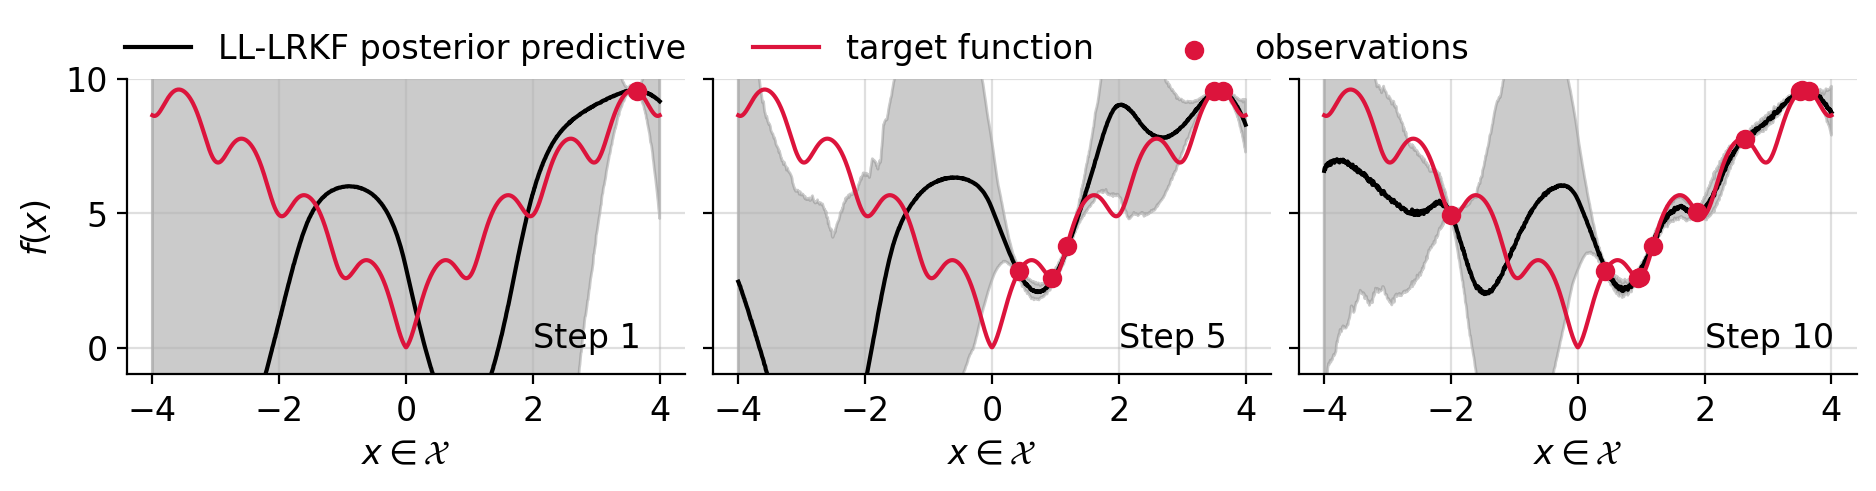

In [224]:
n_vals = [1, 5, 10]
fig, axs = plt.subplots(1, 3, figsize=(6.2 * 1.8, 4.8 * 0.4), sharey=True)
for ax, n in zip(axs, n_vals):
    plt.sca(ax)
    bel_step = jax.tree.map(lambda x: x[n], hist)
    sample_params = agent.sample_params_last_layer(key_sample, bel_step, n_samples=100)
    ysamples = join_eval(sample_params, bel.mean_hidden, xrange[:, None])
    
    lbound = np.quantile(ysamples, 0.1, axis=0)
    ubound = np.quantile(ysamples, 0.9, axis=0)
    
    plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)
    plt.plot(xrange, ysamples.mean(axis=0), c="black", label="LL-LRKF posterior predictive")
    plt.plot(xrange, yvals, c="crimson", label="target function")
    plt.ylim(-1, 10)
    plt.scatter(x_samples[:n], y_samples[:n], zorder=3, c="crimson", label="observations")
    # plt.legend(loc="lower left")
    # plt.plot(xrange, ysamples[:5].T, c="tab:gray");
    plt.grid(alpha=0.4)
    ax.text(2, 0, f"Step {n}")
    ax.set_xlabel(r"$x \in {\cal X}$")
axs[0].set_ylabel("$f(x)$")
plt.legend(ncol=3, bbox_to_anchor=(-0.9, 1.1), loc="center", frameon=False)
fig.subplots_adjust(wspace=0.05)
plt.savefig("../figures/bo-bnn-ackley.png", dpi=300, bbox_inches="tight")

## Steps

## Function maximisation through Thompson sampling

### Surrogate model

In [359]:
key = jax.random.PRNGKey(314)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [364]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_samples)

def cov_fn(y): return 0.0
agent = l3rkf.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(params_init, cov_hidden=1e-3, cov_last=4.0)

In [365]:
hist_y = []
hist_x = []

### Initial sample and update

In [366]:
key_eval = jax.random.fold_in(key_eval, 1)

In [367]:
x_init = jax.random.uniform(key_init_x, shape=(1,), minval=-4, maxval=4)
y_init = ackley_1d(x_init)
(x_init, y_init)

hist_y.append(y_init.item())
hist_x.append(x_init.item())

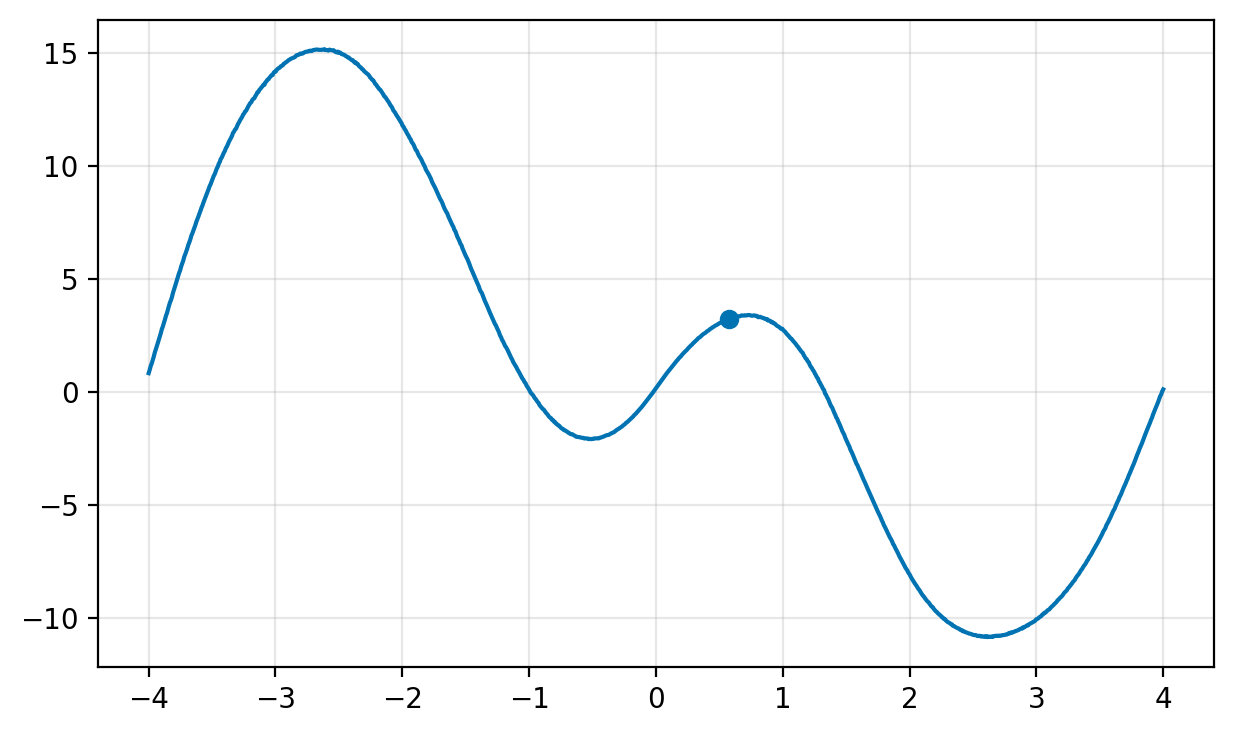

In [368]:
# Update beliefs
bel = agent.update(bel_init, y_init, x_init)

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(x_init, y_init)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Second step

In [369]:
key_eval = jax.random.fold_in(key_eval, 2)

In [370]:
x_next = xrange[fn_sampled.argmin()]
y_next = ackley_1d(x_next)

hist_x.append(x_next.item())
hist_y.append(y_next.item())

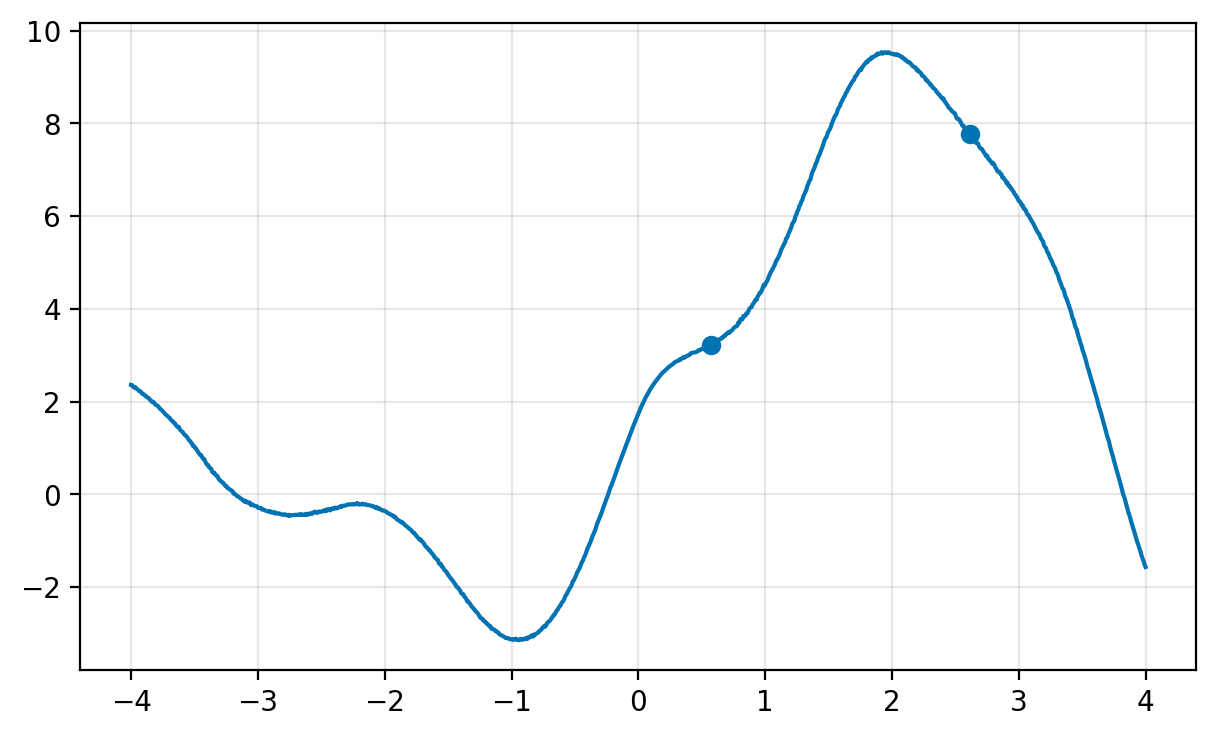

In [371]:
# Update beliefs
bel = agent.update(bel, y_next, jnp.atleast_1d(x_next))

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(hist_x, hist_y)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Third step

In [372]:
key_eval = jax.random.fold_in(key_eval, 3)

In [373]:
x_next = xrange[fn_sampled.argmin()]
y_next = ackley_1d(x_next)

hist_x.append(x_next.item())
hist_y.append(y_next.item())

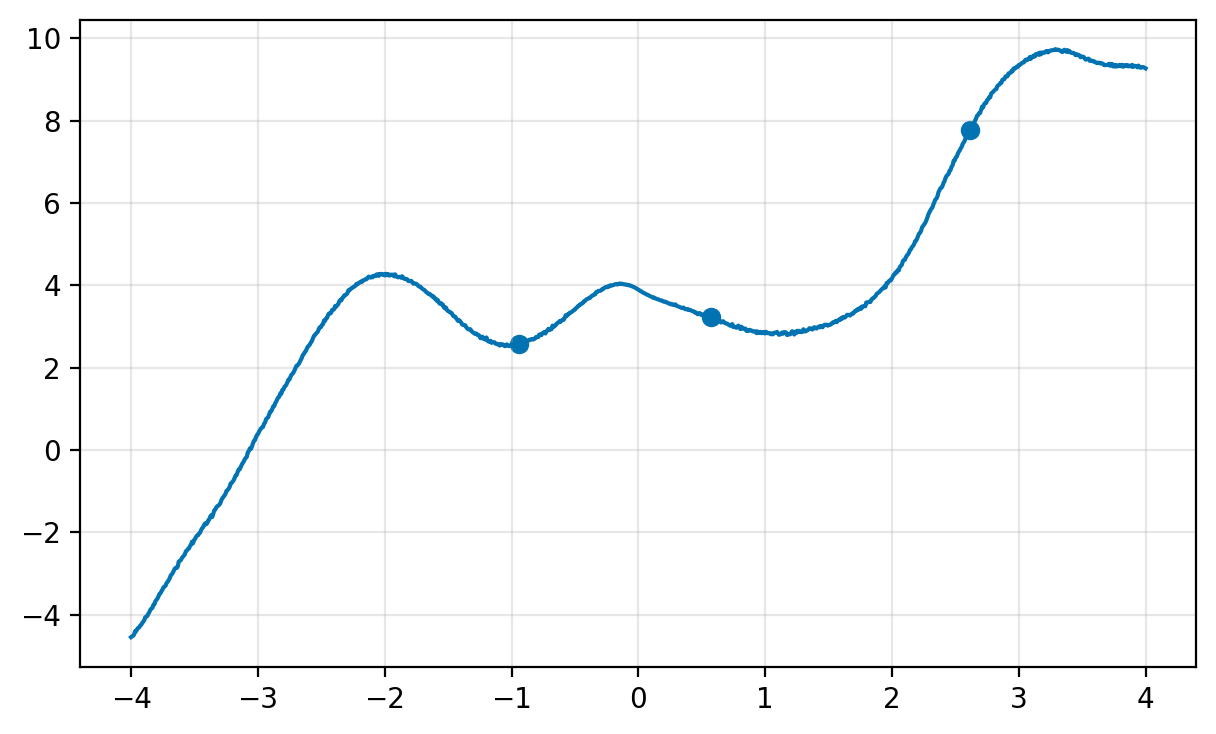

In [374]:
# Update beliefs
bel = agent.update(bel, y_next, jnp.atleast_1d(x_next))

# Sample
ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()

fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])
plt.scatter(hist_x, hist_y)
plt.plot(xrange, fn_sampled)
plt.grid(alpha=0.3)

## Eval

### Initial sample and update

In [375]:
key = jax.random.PRNGKey(31)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [383]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_samples)

def cov_fn(y): return 0.0
agent = l3rkf.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-2, # parameters do not vary much from their initial parameters
    cov_last=10.0 # uncertainty in target
)

In [384]:
def eval_update(state, t, key):
    bel, x_next, y_next = state
    x_next = jnp.atleast_1d(x_next)
    # Update beliefs
    key_eval = jax.random.fold_in(key, t)
    bel = agent.update(bel, y_next, x_next)
    
    ll_params = agent.sample_params_last_layer(key_eval, bel).squeeze()
    fn_sampled = agent.mean_fn(bel.mean_hidden, ll_params, xrange[:, None])

    # Take next point
    x_next = xrange[fn_sampled.argmin()]
    y_next = ackley_1d(x_next).squeeze()

    out = {
        "x": x_next,
        "y": y_next,
        "fn": fn_sampled.squeeze()
    }

    state_next = (bel, x_next, y_next)
    return state_next, out

In [385]:
x_next = jax.random.uniform(key_init_x, minval=-4, maxval=4)
y_next = ackley_1d(x_next)

In [386]:
steps = jnp.arange(15)
state_init = (bel, x_next, y_next)
bel_final, hist = jax.lax.scan(partial(eval_update, key=key_eval), state_init, steps)

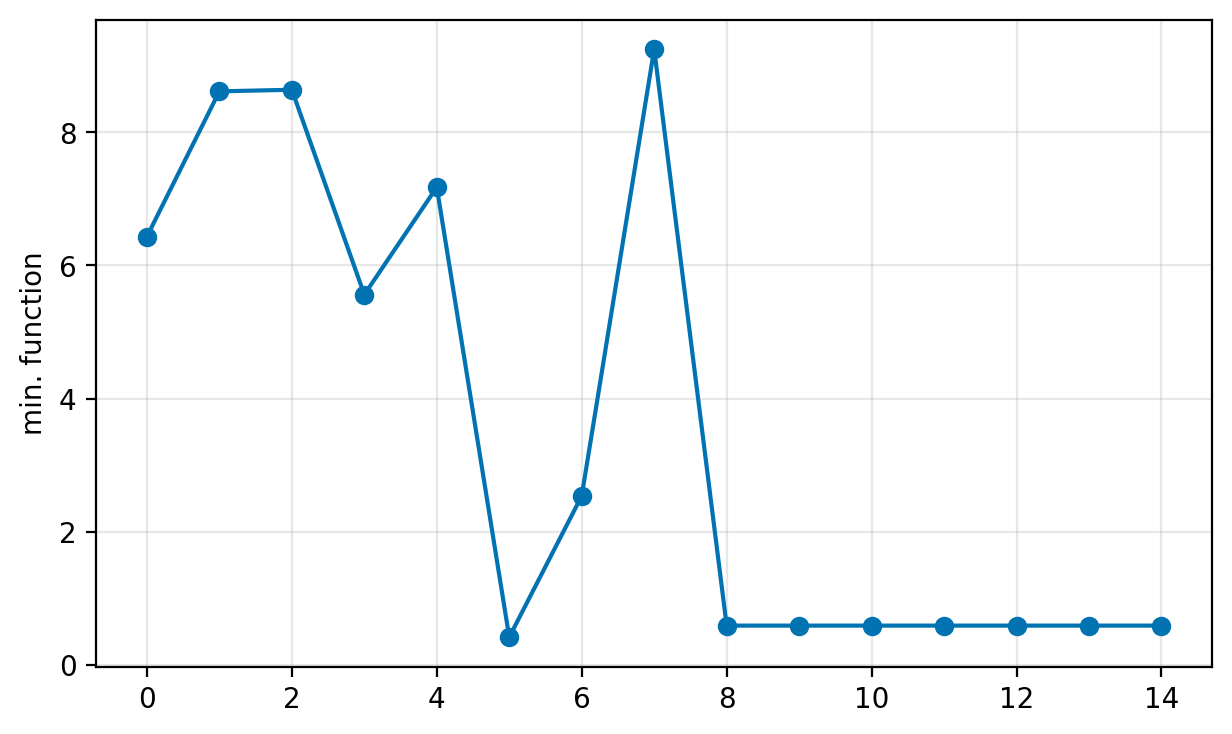

In [387]:
plt.plot(hist["y"], marker="o")
plt.ylabel("min. function")
# plt.yscale("log")
plt.grid(alpha=0.3)

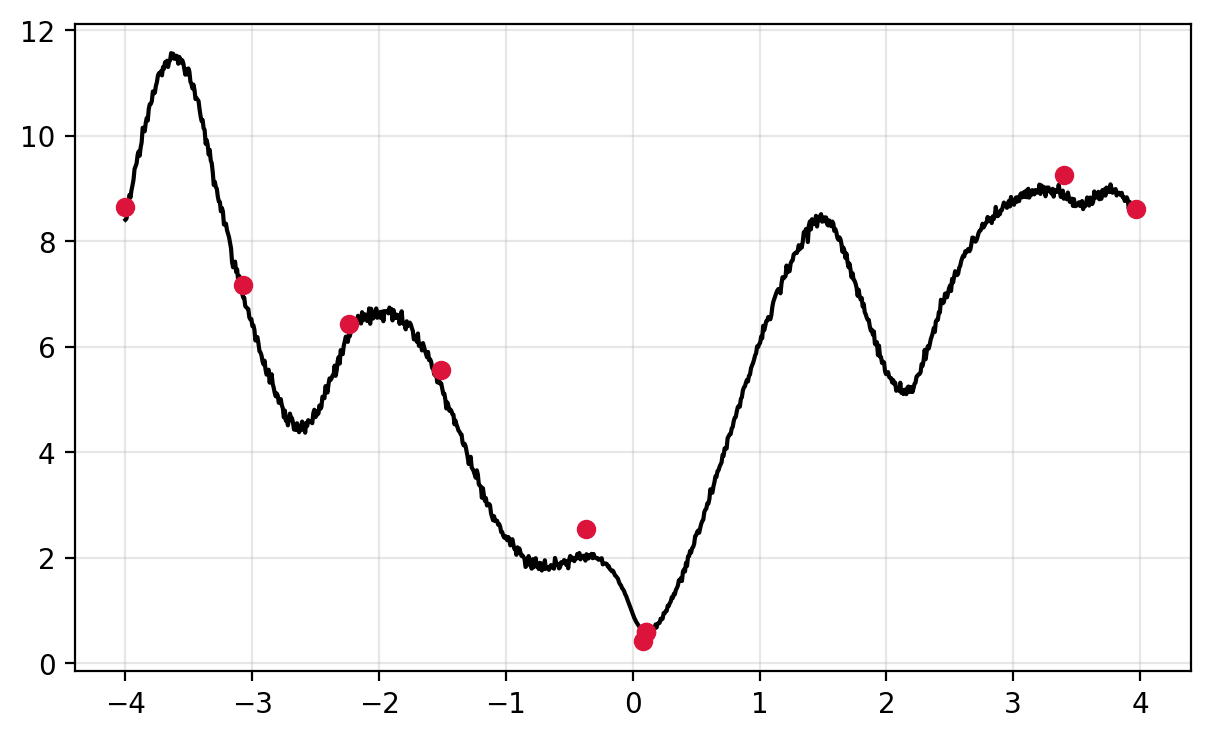

In [388]:
n_obs = 10
plt.plot(xrange, hist["fn"][n_obs], c="black")
plt.scatter(hist["x"][:n_obs], hist["y"][:n_obs], c="crimson", zorder=2)
plt.grid(alpha=0.3)

## Steps

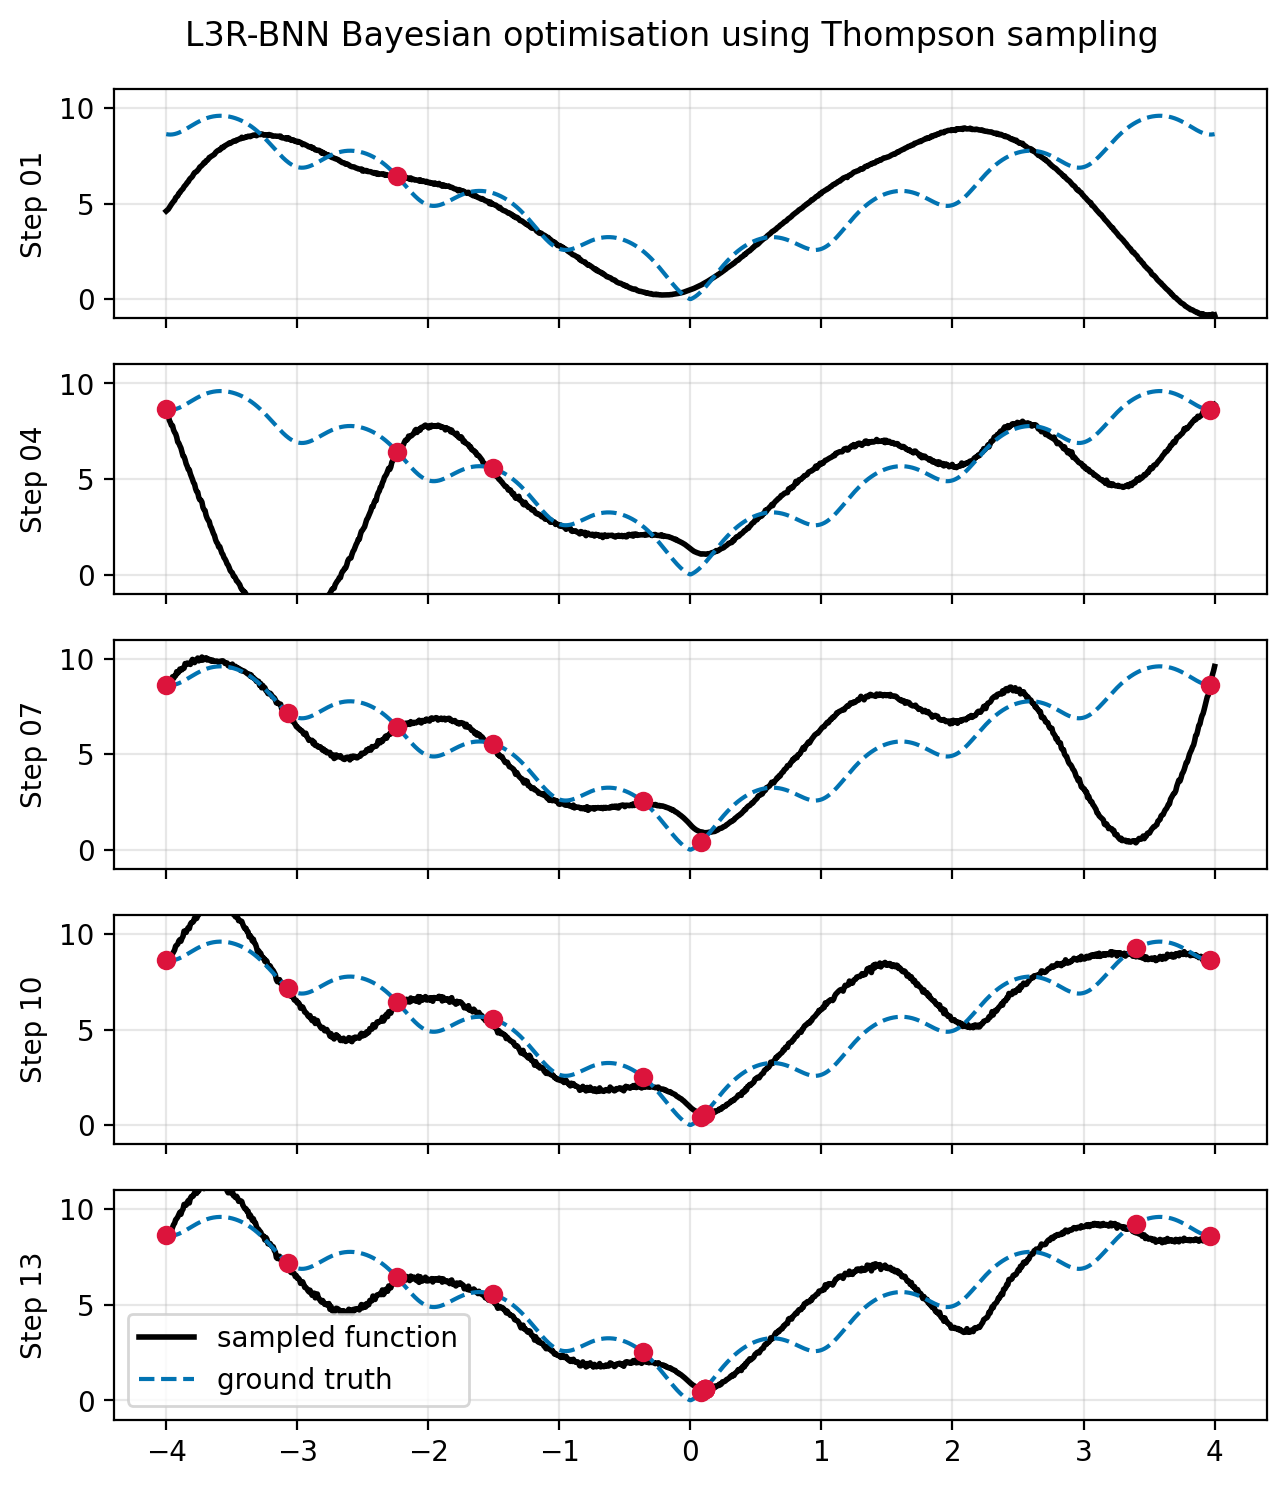

In [389]:
steps = np.arange(1, 15, 3)

n_rows = len(steps)
fig, axs = plt.subplots(n_rows, 1, sharex=True, sharey=True, figsize=(6.2 * 1.2, 4.8 * 1.8))
for n_obs, ax in zip(steps, axs):
    ax.plot(xrange, hist["fn"][n_obs], c="black", linewidth=2, label="sampled function")
    ax.plot(xrange, ackley_1d(xrange), linestyle="--", label="ground truth")
    ax.scatter(hist["x"][:n_obs], hist["y"][:n_obs], c="crimson", zorder=2)
    ax.grid(alpha=0.3)
    ax.set_ylabel(f"Step {n_obs:02}")
    ax.set_ylim(-1.0, 11)
plt.suptitle("L3R-BNN Bayesian optimisation using Thompson sampling", y=0.92)
ax.legend(loc="lower left");